In [1]:
import sys
import csv
import numpy as np
import pandas as pd
from collections import Counter
import sklearn, matplotlib
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
print('python '+sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('sklearn:',sklearn.__version__)
print('matplotlib:',matplotlib.__version__)

python 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.1.5
sklearn: 0.23.2
matplotlib: 3.3.2


### Read case study data into Pandas dataframe

In [3]:
in_file = 'car_listing_data.csv'
data = pd.read_csv(in_file,sep=';')
print('Dataset size:\n\t%d rows x %d columns'%(data.shape[0],data.shape[1]))
data = data.dropna()
print('Size after dropping rows with NA records:\n\t%d rows x %d columns'%(data.shape[0],data.shape[1]))
data.head(11)

Dataset size:
	78321 rows x 12 columns
Size after dropping rows with NA records:
	78297 rows x 12 columns


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224
5,361204569,Basic,Volkswagen,24890,6,2017,20.10.18,22.10.18,125.0,6.0,2,0.048
6,362784907,Basic,Fiat,2850,7,2008,08.11.18,09.11.18,172.0,4.0,1,0.022093023255813953
7,363942101,Basic,Renault,23740,2,2018,20.11.18,15.02.19,1499.0,99.0,87,0.06274182788525684
8,358875204,Basic,Renault,7850,6,2016,24.09.18,08.12.18,4329.0,133.0,75,0.030723030723030724
9,357547566,Basic,Mazda,13950,3,2016,08.09.18,10.10.18,2257.0,89.0,32,0.03943287549844927


#### <font color=red> Note: </font>I discared rows with missing values, since we only have 24 such rows out of 78321. Other possibilitiy is to replace missing value with the average of that fearure column.

### Check the data types of input features

In [4]:
data.dtypes

article_id                   int64
product_tier                object
make_name                   object
price                        int64
first_zip_digit              int64
first_registration_year      int64
created_date                object
deleted_date                object
search_views               float64
detail_views               float64
stock_days                   int64
ctr                         object
dtype: object

# <font color='blue'>Data preprocessing</font> 

### A. Convert created_date and deleted_date from object type to datetime

In [5]:
data["created_date"] = pd.to_datetime(data["created_date"])
data["deleted_date"] = pd.to_datetime(data["deleted_date"])

### B. Split created_date feature column into 3 columns for day, month, and year

In [6]:
data["created_day"] = data['created_date'].map(lambda x: x.day)
data["created_month"] = data['created_date'].map(lambda x: x.month)
data["created_year"] = data['created_date'].map(lambda x: x.year)


print('Distinct created days =',list(Counter(data["created_day"]).keys()))
print('Distinct created months =',list(Counter(data["created_month"]).keys()))
print('Distinct created years =',list(Counter(data["created_year"]).keys()))

data[["created_date","created_year","created_month","created_day"]].head(11)

Distinct created days = [24, 16, 20, 28, 11, 9, 7, 8, 10]
Distinct created months = [7, 8, 10, 11, 9, 4, 12]
Distinct created years = [2018]


,created_date,created_year,created_month,created_day
0,2018-07-24,2018,7,24
1,2018-08-16,2018,8,16
2,2018-07-16,2018,7,16
3,2018-07-20,2018,7,20
4,2018-08-28,2018,8,28
5,2018-10-20,2018,10,20
6,2018-08-11,2018,8,11
7,2018-11-20,2018,11,20
8,2018-09-24,2018,9,24
9,2018-08-09,2018,8,9


#### <font color='red'>We notice from the output of the cell above that all datapoints (rows) were created in the year 2018, we can discard this feature since it does not have valuable information to predict product tier or price.</font>

### C. Similarly, split deleted_day feature into 3 columns for day, month, and year

In [7]:

data["deleted_day"] = data['deleted_date'].map(lambda x: x.day)
data["deleted_month"] = data['deleted_date'].map(lambda x: x.month)
data["deleted_year"] = data['deleted_date'].map(lambda x: x.year)

#number of distinct days, months, and years
print('Distinct deleted days =',list(Counter(data["deleted_day"]).keys()))
print('Distinct deleted months =',list(Counter(data["deleted_month"]).keys()))
print('Distinct deleted years =',list(Counter(data["deleted_year"]).keys()))
data[["deleted_date","deleted_year","deleted_month","deleted_day"]].head(11)

Distinct deleted days = [24, 10, 9, 29, 22, 11, 15, 12, 19, 28, 8, 31, 17, 27, 26, 21, 1, 23, 13, 25, 18, 16, 20, 30, 14, 2, 3, 7, 4]
Distinct deleted months = [8, 7, 5, 10, 9, 2, 11, 1, 3, 12, 4, 6]
Distinct deleted years = [2018, 2019]


,deleted_date,deleted_year,deleted_month,deleted_day
0,2018-08-24,2018,8,24
1,2018-07-10,2018,7,10
2,2018-05-09,2018,5,9
3,2018-10-29,2018,10,29
4,2018-08-09,2018,8,9
5,2018-10-22,2018,10,22
6,2018-09-11,2018,9,11
7,2019-02-15,2019,2,15
8,2018-08-12,2018,8,12
9,2018-10-10,2018,10,10


### D. Encode product manufacturer (make_name) by mapping each manufacturer (make_name) to a unique value and transform the data to an ordinal encoding

In [8]:
# convert the manufacturer names to categorical data
data["make_name"] = data["make_name"].astype('category')
#Encode product manufacturer (make_name), map each manufacturer (make_name) to unique value and transform the data to an ordinal encoding
ord_enc = OrdinalEncoder()
data["make_id"] = ord_enc.fit_transform(data[["make_name"]])
data[["make_id", "make_name"]].head(11)

,make_id,make_name
0,62.0,Mitsubishi
1,60.0,Mercedes-Benz
2,60.0,Mercedes-Benz
3,33.0,Ford
4,60.0,Mercedes-Benz
5,88.0,Volkswagen
6,32.0,Fiat
7,73.0,Renault
8,73.0,Renault
9,58.0,Mazda


### E. Conver ctr feature to float64



When trying to convert ctr column values to float, I got the error message (copied below).

`data["ctr"] = data["ctr"].astype('float64')`

<font color='red'>ValueError:</font> could not convert string to float: '27.624.309.392.265.100'


I worked around this by recomputing the Click Through Rate based on the description provided in AS24_Data_Description.csv

In [9]:
#Click through rate calculated as the quotient of detail_views over search_views
data["ctr_new"] = data["detail_views"]/data["search_views"]
data[["ctr", "ctr_new"]].head(11)

,ctr,ctr_new
0,0.03780329990294403,0.039793
1,0.06792567773378008,0.067926
2,0.0816137973514013,0.081614
3,0.014008620689655173,0.014009
4,0.04081632653061224,0.040816
5,0.048,0.048000
6,0.022093023255813953,0.023256
7,0.06274182788525684,0.066044
8,0.030723030723030724,0.030723
9,0.03943287549844927,0.039433


In [10]:
# print('Click Through Rate feature stats:')
# print('\tMin CTR =',min(data["ctr_new"]))
# print('\tMax CTR =',max(data["ctr_new"]))
# CTR_mean = np.mean(data["ctr_new"])
# CTR_std = np.std(data["ctr_new"])
# print("\tMean CTR = %0.2f"%CTR_mean)
# print("\tStandard deviation = %.2f"%CTR_std)

# # Normalize
# data["adj_ctr_new"] = (data["ctr_new"] - price_mean)/price_std
# data[["adj_ctr_new"]].head(11)

### F. Scale price feature values 

In [11]:
# takes a wide range of values, therefore I normalize it by subtracting the mean of the input feature and divide by the standard deviation.
print('Price feature stats:')
print('\tMin price =',min(data["price"]))
print('\tMax price =',max(data["price"]))
price_mean = np.mean(data["price"])
price_std = np.std(data["price"])
print("\tMean price = %0.2f"%price_mean)
print("\tStandard deviation = %.2f"%price_std)

# Normalize
data["adj_price"] = (data["price"] - price_mean)/price_std
data[["price", "adj_price"]].head(11)

Price feature stats:
	Min price = 50
	Max price = 249888
	Mean price = 15069.67
	Standard deviation = 16375.49


,price,adj_price
0,16750,0.102612
1,35950,1.275096
2,11950,-0.190508
3,1750,-0.813390
4,26500,0.698014
5,24890,0.599697
6,2850,-0.746217
7,23740,0.529470
8,7850,-0.440883
9,13950,-0.068375


In [12]:
data.dtypes

article_id                          int64
product_tier                       object
make_name                        category
price                               int64
first_zip_digit                     int64
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr                                object
created_day                         int64
created_month                       int64
created_year                        int64
deleted_day                         int64
deleted_month                       int64
deleted_year                        int64
make_id                           float64
ctr_new                           float64
adj_price                         float64
dtype: object


# <font color='blue'>Preparing training and test data</font>

In [13]:
# Select feature list
feature_list = ['first_zip_digit','first_registration_year','search_views','detail_views','stock_days',\
               'created_day','created_month','deleted_day','deleted_month','deleted_year','adj_price','make_id',"ctr_new"]
label = ['product_tier']
# split input data and labels
X = data[feature_list]
print('Data size:',X.shape)
y = data[label]
print('Labels size:',y.shape)

Data size: (78297, 13)
Labels size: (78297, 1)


### A. Split case study data to 67% training and 33% test

In [14]:
#stratify=y will make sure that your random split has equal proportion of each class label
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### B. Encode target labels with value [0, n_classes-1], i.e., 0, 1, 2.

In [15]:
print('All:',Counter(y['product_tier']))
print('Train:',Counter(y_train['product_tier']))
print('Test:',Counter(y_test['product_tier']))

All: Counter({'Basic': 75397, 'Premium': 2324, 'Plus': 576})
Train: Counter({'Basic': 50515, 'Premium': 1557, 'Plus': 386})
Test: Counter({'Basic': 24882, 'Premium': 767, 'Plus': 190})


In [16]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

/Users/isra/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# <font color='blue'>Create a Random Forest Classifier</font>

#### The Random forest classifier is flexible and easy to use, basically it is composed of decision trees, it selects the best prediction by means of voting. Further, it can provide feature importance score. One of its main application is recommendation engines.

### A. Train the model using the training set

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=50)
#clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
clf.fit(x_train,y_train_enc)

RandomForestClassifier(n_estimators=50)

### B. Evaluate model Accuracy

In [18]:
y_pred = clf.predict(x_test)
acc = metrics.accuracy_score(y_test_enc, y_pred)*100
print("Accuracy: %.3f%%" %acc)

print('Confusion matrix:')
print(confusion_matrix(y_test_enc, y_pred))

Accuracy: 97.020%
Confusion matrix:
[[24799     0    83]
 [  180     0    10]
 [  497     0   270]]


In [19]:
# just to check the label counts that the model predicted compared to ground truth label counts
print(Counter(y_pred))
print(Counter(y_test_enc))

Counter({0: 25476, 2: 363})
Counter({0: 24882, 2: 767, 1: 190})


### C. Get and visulaize feature importance score

In [20]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

search_views               0.205181
stock_days                 0.144418
detail_views               0.135747
ctr_new                    0.108344
adj_price                  0.087014
first_registration_year    0.056559
make_id                    0.054287
deleted_day                0.052156
first_zip_digit            0.041038
deleted_month              0.039258
created_day                0.035263
created_month              0.031373
deleted_year               0.009360
dtype: float64

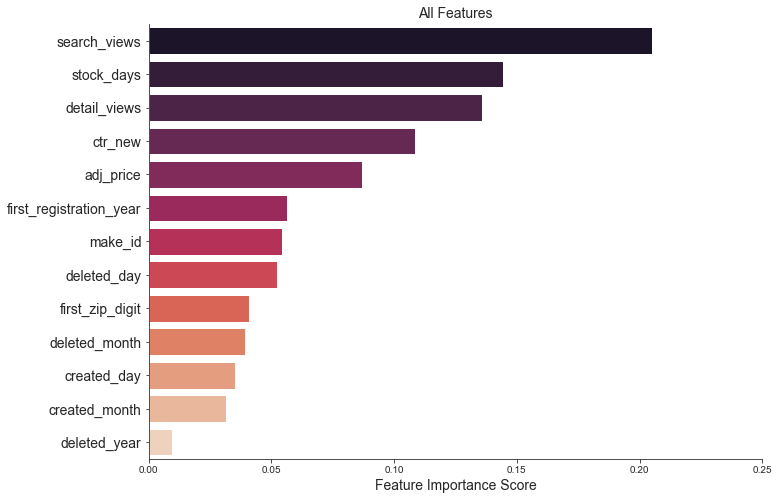

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#plt.rcParams["font.family"] = 'Comic Sans MS'


sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.despine()
sns.set(font_scale = 1)
# Creating a bar plot
b = sns.barplot(x=feature_imp, y=feature_imp.index, palette="rocket")
b.set_yticklabels(feature_imp.index, size = 14)
#b.set_xticklabels(['%.2f' % v for v in feature_imp.values], size=14)
#b.set_xticklabels(np.arange(0.,0.35,0.05), size=14)
plt.xlim(0.0,0.25)
plt.xlabel('Feature Importance Score',fontsize=14)
plt.ylabel('',fontsize=14)
plt.title("All Features",fontsize=14)
plt.show()

### D. Re-run the model on the most important features (out of curiosity)

In [22]:
feature_list = ['search_views']#,'detail_views','stock_days','adj_price',"ctr_new"]
label = ['product_tier']

# split input data and labels
#stratify=y will make sure that your random split has equal proportion of each class label
X2 = data[feature_list]
y2 = data[label]
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42, stratify=y)

le = preprocessing.LabelEncoder()
le.fit(y_train2)
y_train_enc2 = le.transform(y_train2)
y_test_enc2 = le.transform(y_test2)

clf2=RandomForestClassifier(n_estimators=50, verbose=0)
clf2.fit(x_train2,y_train_enc2)

y_pred2 = clf2.predict(x_test2)
acc2 = metrics.accuracy_score(y_test_enc2, y_pred2)*100
print("Accuracy: %.3f%%" %acc2)

print('Confusion matrix:')
print(confusion_matrix(y_test_enc2,y_pred2))

/Users/isra/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 95.306%
Confusion matrix:
[[24489    63   330]
 [  170     1    19]
 [  613    18   136]]


In [23]:
# just to check the label counts that the model predicted compared to ground truth label counts
# I was afraid that the model would predicts all label as 0 since its the dominant class label
print(Counter(y_pred2))
print(Counter(y_test_enc2))

Counter({0: 25272, 2: 485, 1: 82})
Counter({0: 24882, 2: 767, 1: 190})


### <font color='green'>Notes:</font> 

* Using all features, the classifiers achieves accuracy of approx. 97%
* Using the top 5 feature achieves approx. 96.9% prediction accuracy.
* It was enough to have the single feature 'search_views'  to get approx. 95.3% prediction accuracy.

### Resources
* https://scikit-learn.org/
* https://machinelearningmastery.com/
* https://www.datacamp.com/community/tutorials/random-forests-classifier-python